*Author: Piotr Kaniewski 27-09-2024*

# Node2Vec (GDS) in KGML-xDTD pipeline

**Background:** as we were worried about data leakage being encoded in node attribute embeddings generated by LLMs (or all pre-trained models) we should consider other methods which dont utilize such pre-trained models. One such  as an alternative to use methods which don't utilize feature properties - such as Node2vec. This was tested at some point by  Chunyu as well, so we know it's possible to integrate it within KGML-xDTD pipeline

**Motivation:** This experiment will tell us:
* how well we can predict drug-disease pairs for repurposing using ONLY our knowledge graph connectivity (as Node2vec doesn't utilize feature properties)
  * if post-node2vec performance is significantly worse, that shows that there is likely a data leakage encoded in the OpenAI/node embedding. We won't get a data leakage answer with 100% confidence (this comes down to the discussion what is enrichment and what is leakage) but it will give  us some good answers on the connectivity of RTX-KG2 and its importance in predictive modelling
* the role of node attribute in the process of predictive modelling (i.e. is graphsage or node2vec better?)

**Results:** Node2vec seemed to outperform GraphSage in terms of downstream task performance across all models and across majority of metrics. Furthermore it also outperformed Chunyu's random forest/xgboost synth (graphsage-based) which we treated as a main point of reference.

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier                   
from sklearn.model_selection import train_test_split     

## About Node2vec implementation in Neo4J

Neo4j implementation of node2vec not identical to its original implementation. This is because the Node2vec from GDS is:

* non-deterministic - we can set a random seed for random walk but for initial embedding vector we cant do that, as this embedding vector is sampled from a distribution from -a to a, and we can only fix a
  * note that even though it is not deterministic, through training we should be able to 'converge' the topological embeddings to the same level

* written in Java - different way of random sampling etc
* slightly different parameters and way of controlling loss

### Reproducible despite being non-deterministic
Note that although GDS Node2Vec is technically non-deterministic, my experiment in *lab-notebooks* showed that through training we can get the same latent decomposition of the embeddings; they also come from the same statistical distribution post-training. 

Below example shows latent factor being consistent across several runs (PCA example) - although at first glance the plots look different, the shape is the same and so is the distribution.

*For details see [lab-notebooks report](https://github.com/everycure-org/lab-notebooks/tree/main/node2vec_exploration)*

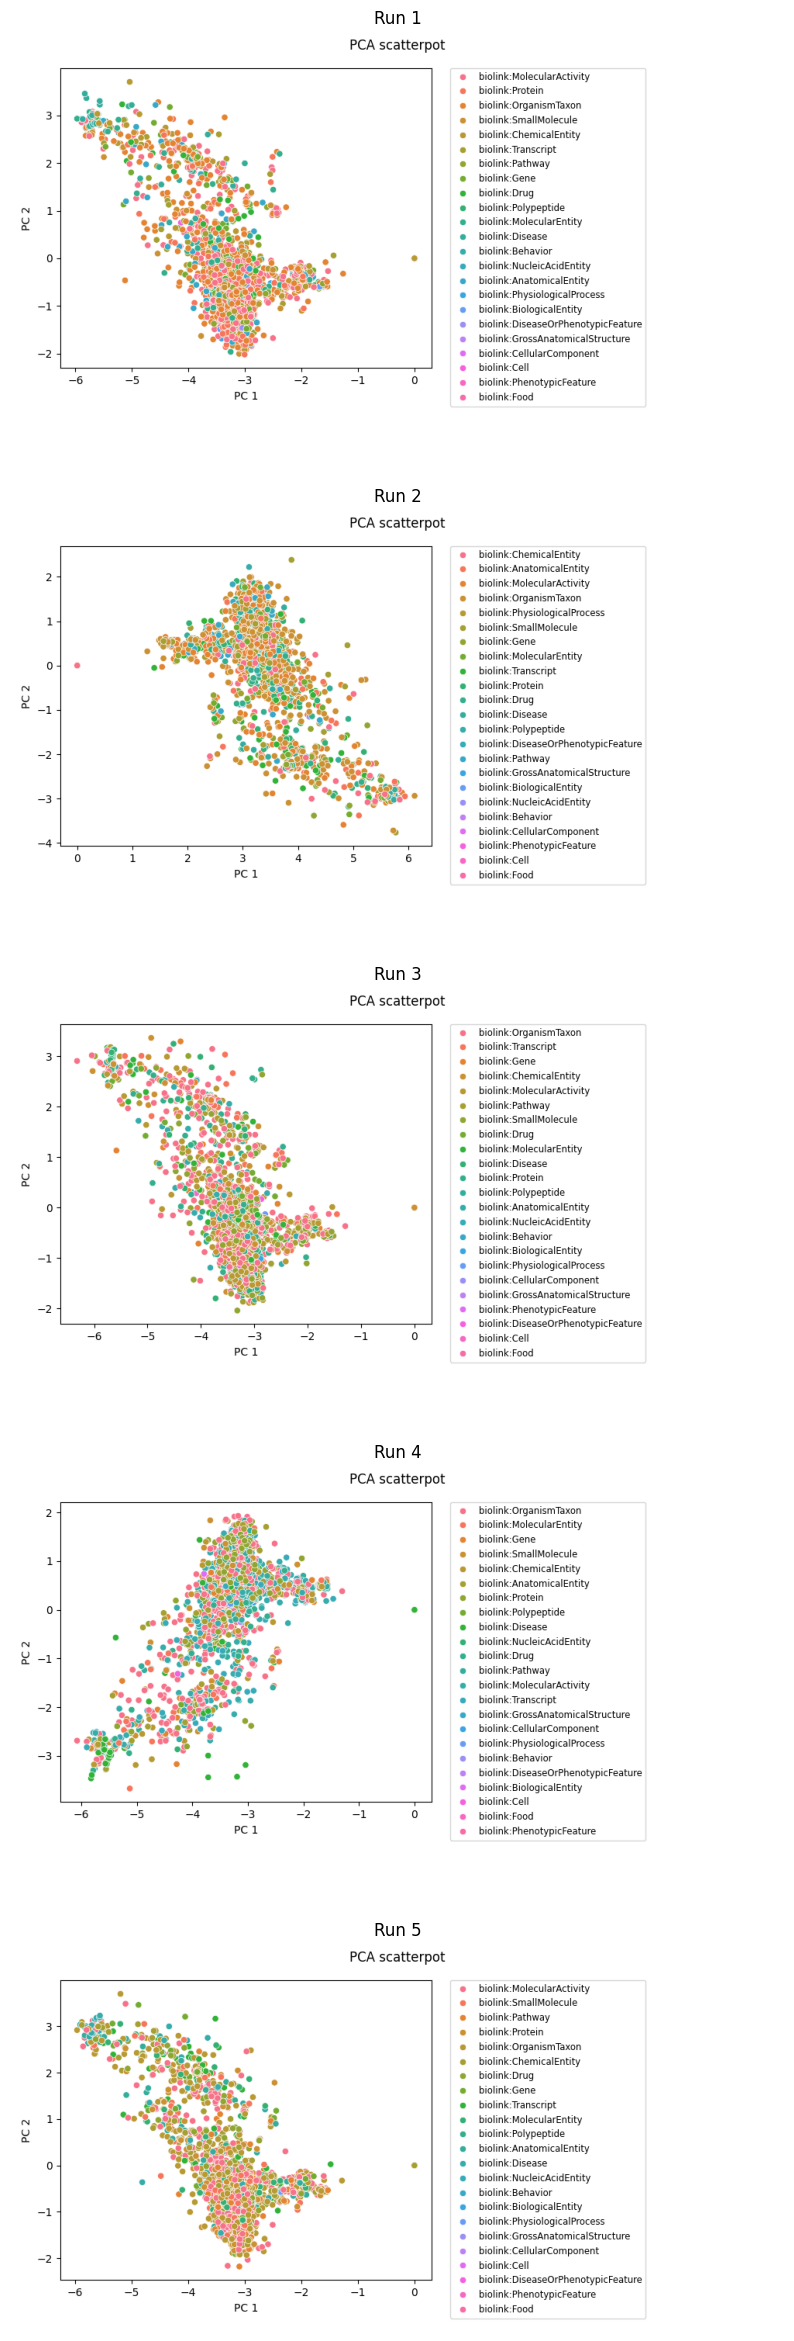

In [22]:
from PIL import Image
import matplotlib.pyplot as plt 


# Create a matplotlib figure
plt.subplots(5, 1, figsize=(10,30))
for i in range(1,6):
    img = Image.open(f'scratch/pca_1000/pca_plot_{i}.png')
    plt.subplot(5, 1, i)
    plt.imshow(img)
    plt.axis('off')  # Hide the axes
    plt.title(f'Run {i}')

plt.tight_layout
# Show the plots
plt.show()


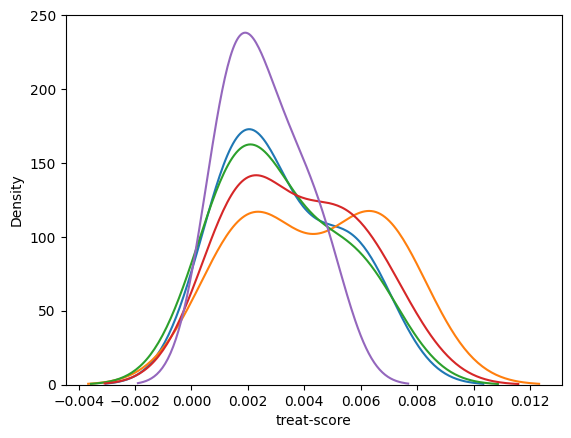

In [189]:
for i in range(5):
    sns.kdeplot((preds_dict[f'setup_{i}']['treat-score']))

## Node2Vec and Downstream Task Performance - Full Data Example

We used the following parameters (see below) to train node2vec for topological embedding generation to examine whether we can reach the same performance as with GraphSage in our current pipeline (as of Sept. 2024)

### Parameters


Note that we chose 10 iterations as 100 iterations would take a very long time - 100 iterations will be examined in the second round. 

* object: matrix.pipelines.embeddings.graph_algorithms.GDSNode2Vec 

* concurrency: 4

* embedding_dim: 512

* random_seed: 42

* iterations: 10

* in_out_factor: 1

* return_factor: 1

* initial_learning_rate: 0.025

* min_learning_rate: 0.000025

* negative_sampling_rate: 5

* walk_length: 30

* walks_per_node: 10

* window_size: 10


## PCA 

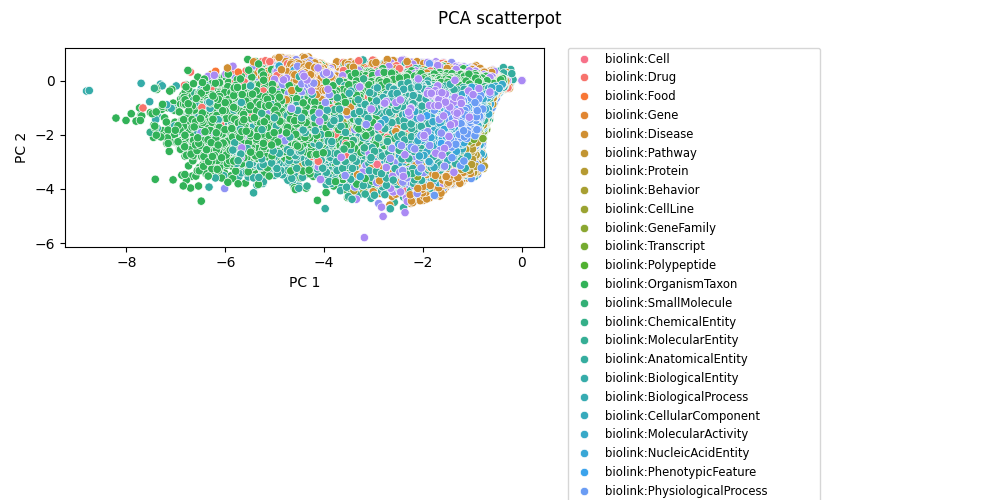

In [2]:
from PIL import Image

Image.open('pca_node2vec-iter10.png')

Although not very similar to the PCAs from sampled graph (see above), the latent space is very similar to the PCAs obtained from topological embeddings of full data obtained GraphSage. 

### Model Performance Results 

As a part of e2e run, bayesian HPO was conducted and several models were trained - random forest, xgboost, xgboost with synthetic data and ensemble of xgboost (re-sampled models).


#### Node2Vec 

In [5]:

# For details on how to get the table from MLflow see ttps://github.com/everycure-org/lab-notebooks/tree/main/node2vec_exploration

,rf,xg_synth,xg_ensemble,xg_baseline
test_accuracy,0.900787,0.924217,0.873879,0.925499
test_macro_f1,0.602974,0.624030,0.603841,0.619082
simple_ground_truth_classification_time_split_accuracy_score,0.430556,0.444444,0.180556,0.666667
simple_ground_truth_classification_time_split_f1_score,0.594059,0.607843,0.289157,0.800000
simple_ground_truth_classification_accuracy_score,0.887608,0.929160,0.892916,0.925499
simple_ground_truth_classification_f1_score,0.840437,0.904089,0.844951,0.900172
continuous_ground_truth_classification_roc_auc_score,0.969426,0.979746,0.980534,0.977965
continuous_ground_truth_classification_average_precision_score,0.953428,0.971192,0.970671,0.967336
disease_specific_ranking_time_split_mrr,0.029949,0.025403,0.019726,0.005230
disease_specific_ranking_time_split_hit-2,0.000000,0.025641,0.000000,0.000000


Below you can find how these results compare with the most recent  e2e run using GraphSage (our current state of Main)

In [6]:
# GraphSage (default pipeline)

,rf,xg_synth,xg_ensemble,xg_baseline
test_accuracy,0.902618,0.909207,0.835255,0.900055
test_macro_f1,0.604045,0.613878,0.580758,0.601526
simple_ground_truth_classification_time_split_accuracy_score,0.444444,0.430556,0.180556,0.625000
simple_ground_truth_classification_time_split_f1_score,0.615385,0.601942,0.305882,0.769231
continuous_ground_truth_classification_roc_auc_score,0.965335,0.974032,0.965960,0.967091
continuous_ground_truth_classification_average_precision_score,0.948756,0.960750,0.948574,0.951282
simple_ground_truth_classification_accuracy_score,0.896028,0.915614,0.859418,0.898041
simple_ground_truth_classification_f1_score,0.857071,0.884894,0.789011,0.858952
disease_specific_ranking_time_split_mrr,0.012817,0.008995,0.032751,0.010569
disease_specific_ranking_time_split_hit-2,0.000000,0.000000,0.025641,0.000000


#### GraphSage and Node2Vec comparison

In [8]:
# GraphSage and node2vec comparison table 

,rf_graphsage,xg_synth_graphsage,xg_ensemble_graphsage,xg_baseline_graphsage,rf_n2v,xg_synth_n2v,xg_ensemble_n2v,xg_baseline_n2v
test_accuracy,0.902618,0.909207,0.835255,0.900055,0.900787,0.924217,0.873879,0.925499
test_macro_f1,0.604045,0.613878,0.580758,0.601526,0.602974,0.624030,0.603841,0.619082
simple_ground_truth_classification_time_split_accuracy_score,0.444444,0.430556,0.180556,0.625000,0.430556,0.444444,0.180556,0.666667
simple_ground_truth_classification_time_split_f1_score,0.615385,0.601942,0.305882,0.769231,0.594059,0.607843,0.289157,0.800000
simple_ground_truth_classification_accuracy_score,0.896028,0.915614,0.859418,0.898041,0.887608,0.929160,0.892916,0.925499
simple_ground_truth_classification_f1_score,0.857071,0.884894,0.789011,0.858952,0.840437,0.904089,0.844951,0.900172
continuous_ground_truth_classification_roc_auc_score,0.965335,0.974032,0.965960,0.967091,0.969426,0.979746,0.980534,0.977965
continuous_ground_truth_classification_average_precision_score,0.948756,0.960750,0.948574,0.951282,0.953428,0.971192,0.970671,0.967336
disease_specific_ranking_time_split_mrr,0.012817,0.008995,0.032751,0.010569,0.029949,0.025403,0.019726,0.005230
disease_specific_ranking_time_split_hit-2,0.000000,0.000000,0.025641,0.000000,0.000000,0.025641,0.000000,0.000000


We can see that the only cases when graphsage is better is for time-split validation. While this is purely a hypothetical assumption, one can say thats due to data leakage as we cant control openai text embeddings and what is the coverage of the data used for training those.

### Node2Vec & Chunyus results

Although the results look promising already, it is important to also look at how the results compare to Chunyu's models (random forest and xg synth trained on pubmedbert & GraphSage). Up until now, Chunyu's models were still better than ours (could be due to us using OpenAI embedding models as well as different parameters for graphsage (which was also customly implemented))

In [10]:
# Random Forest Comparison

,rf_chunyu,rf_graphsage,rf_n2v
disease_centric_matrix_roc_auc_score,0.741243,0.727164,0.745602
disease_centric_matrix_average_precision_score,0.006884,0.003399,0.007762
disease_specific_ranking_mrr,0.129286,0.076712,0.174579
disease_specific_ranking_hit-2,0.120336,0.066698,0.159515
disease_specific_ranking_hit-10,0.197295,0.131063,0.285914
disease_specific_ranking_hit-100,0.423041,0.316698,0.509795
simple_ground_truth_classification_f1_score,0.882482,0.857071,0.840437
test_accuracy,0.833420,0.902618,0.900787


In [11]:
# XG synth comparison

,xg_synth_chunyu,xg_synth_graphsage,xg_synth_n2v
disease_centric_matrix_roc_auc_score,0.867708,0.842365,0.878373
disease_centric_matrix_average_precision_score,0.019273,0.007706,0.020894
disease_specific_ranking_mrr,0.153431,0.104139,0.169174
disease_specific_ranking_hit-2,0.132929,0.085821,0.145522
disease_specific_ranking_hit-10,0.271455,0.175840,0.306903
disease_specific_ranking_hit-100,0.578358,0.446828,0.637593
simple_ground_truth_classification_f1_score,0.926231,0.884894,0.904089
test_accuracy,0.900074,0.909207,0.924217


This confirms that swapping graphsage with node2vec outperforms Chunyu's models as well, which is something we havent achieved before!

# Reproducibility
As Neo4j Node2vec is not fully deterministic (cant control the randomness of initial embedding vectorization) I repeated the training with exactly the same parameters to ensure we do get the same results. The work done on a subsample already shows that upon several training iterations the topological embeddings converge to statistically same values (i.e. they all come from the same distributions; PCA plots look identical). The following run also shows that downstream task performance is essentially unchanged:

        Mlflow run `node2vec-reproduce-v2`

In [13]:
# node2vec - reproducible results 

,rf,xg_ensemble,xg_baseline
test_macro_f1,0.602935,0.605056,0.619053
disease_centric_matrix_time_split_average_precision_score,0.001252,0.001590,0.000216
disease_specific_ranking_time_split_mrr,0.028905,0.017697,0.003878
disease_specific_ranking_time_split_hit-100,0.256410,0.256410,0.076923
simple_ground_truth_classification_time_split_accuracy_score,0.430556,0.211268,0.680556
simple_ground_truth_classification_f1_score,0.840519,0.848212,0.901663
disease_centric_matrix_time_split_roc_auc_score,0.596080,0.781754,0.518104
disease_specific_ranking_time_split_hit-10,0.076923,0.076923,0.000000
simple_ground_truth_classification_time_split_f1_score,0.594059,0.333333,0.809917
simple_ground_truth_classification_accuracy_score,0.887608,0.895113,0.926414


In [26]:
# % difference highlighted

,rf_v0,xg_ensemble_v0,xg_baseline_v0,rf_v1,xg_synth_v1,xg_ensemble_v1,xg_baseline_v1,rf_diff,xg_ensemble_diff,xg_baseline_diff
test_macro_f1,0.602935,0.605056,0.619053,0.602974,0.624030,0.603841,0.619082,0.000064,0.002015,0.000047
disease_centric_matrix_time_split_average_precision_score,0.001252,0.001590,0.000216,0.000539,0.000795,0.001128,0.000251,0.569675,0.369362,0.028000
disease_specific_ranking_time_split_mrr,0.028905,0.017697,0.003878,0.029949,0.025403,0.019726,0.005230,0.036111,0.070166,0.046762
disease_specific_ranking_time_split_hit-100,0.256410,0.256410,0.076923,0.230769,0.333333,0.333333,0.102564,0.100000,0.300000,0.100000
simple_ground_truth_classification_time_split_accuracy_score,0.430556,0.211268,0.680556,0.430556,0.444444,0.180556,0.666667,0.000000,0.071331,0.032258
simple_ground_truth_classification_f1_score,0.840519,0.848212,0.901663,0.840437,0.904089,0.844951,0.900172,0.000099,0.003880,0.001775
disease_centric_matrix_time_split_roc_auc_score,0.596080,0.781754,0.518104,0.588781,0.695399,0.775043,0.544750,0.012245,0.011259,0.044702
disease_specific_ranking_time_split_hit-10,0.076923,0.076923,0.000000,0.102564,0.051282,0.076923,0.000000,0.333333,0.000000,0.000000
simple_ground_truth_classification_time_split_f1_score,0.594059,0.333333,0.809917,0.594059,0.607843,0.289157,0.800000,0.000000,0.074364,0.016694
simple_ground_truth_classification_accuracy_score,0.887608,0.895113,0.926414,0.887608,0.929160,0.892916,0.925499,0.000000,0.002475,0.001031


We can see very subtle differences for most metrics and across all models; the % difference across is rather small except for some metrics (eg average precision score for rf_diff) but when that's the case, the value itself is very small, so large % change is not necessarily surprising. 

We would need several more node2vec runs with the same parameters (and ideally a separate experiment with a greater number of epochs to see whether the stability is even greater) nevertheless those preliminary results + sample results indicate stable runs.

# Node2Vec vs GraphSage Matrices comparison
As we are mostly interested in the drug-disease matrix as the final output of our pipeline, I compared the matrix generated using our main branch with the matrix generated using Node2Vec as our embedding step. The models and metrics were unchanged and the only variable which was changes was the topological embedding calculation

*Note: this matrix had to be generated locally on my machine as the e2e cluster run encountered an error which is now fixed. Therefore the matrix results can be found in gdrive:*

*Note no.2: for more thorough analysis refer to the notebook within [lab-notebooks report](https://github.com/everycure-org/lab-notebooks/tree/main/node2vec_exploration)*

In [1]:
n2v_matrix = pd.read_csv('/Users/piotrkaniewski/work/matrix/pipelines/matrix/data/xg_ensemble_2-10/matrix_report')
org_cols = list(n2v_matrix.columns)
n2v_matrix['pair']=n2v_matrix['drug_id'] + '|'+n2v_matrix['disease_id']
n2v_matrix

,drug_id,drug_name,disease_id,disease_name,treat score,is_known_positive,is_known_negative,pair
0,CHEMBL.COMPOUND:CHEMBL1628385,PROCAINE BENZYLPENICILLIN,MONDO:0005866,mycobacterium avium complex disease,1.000000,False,False,CHEMBL.COMPOUND:CHEMBL1628385|MONDO:0005866
1,CHEMBL.COMPOUND:CHEMBL1200881,MINOCYCLINE HYDROCHLORIDE,MONDO:0005866,mycobacterium avium complex disease,0.999999,False,False,CHEMBL.COMPOUND:CHEMBL1200881|MONDO:0005866
2,CHEMBL.COMPOUND:CHEMBL1628385,PROCAINE BENZYLPENICILLIN,MONDO:0005631,actinomycosis,0.999999,True,False,CHEMBL.COMPOUND:CHEMBL1628385|MONDO:0005631
3,CHEMBL.COMPOUND:CHEMBL3184791,STREPTOMYCIN SULFATE,MONDO:0005866,mycobacterium avium complex disease,0.999998,False,False,CHEMBL.COMPOUND:CHEMBL3184791|MONDO:0005866
4,CHEMBL.COMPOUND:CHEMBL1628385,PROCAINE BENZYLPENICILLIN,MONDO:0015306,Lemierre syndrome,0.999997,False,False,CHEMBL.COMPOUND:CHEMBL1628385|MONDO:0015306
...,...,...,...,...,...,...,...,...
99995,CHEMBL.COMPOUND:CHEMBL157101,KETOCONAZOLE,MONDO:0006723,denture stomatitis,0.514613,False,False,CHEMBL.COMPOUND:CHEMBL157101|MONDO:0006723
99996,CHEMBL.COMPOUND:CHEMBL3833373,AVELUMAB,MONDO:0011508,"lymphoma, non-Hodgkin, familial",0.514611,False,False,CHEMBL.COMPOUND:CHEMBL3833373|MONDO:0011508
99997,CHEMBL.COMPOUND:CHEMBL541,BENZOIC ACID,MONDO:0001794,Pthirus pubis infestation,0.514601,False,False,CHEMBL.COMPOUND:CHEMBL541|MONDO:0001794
99998,CHEMBL.COMPOUND:CHEMBL567,PERPHENAZINE,MONDO:0018696,corticobasal syndrome,0.514600,False,False,CHEMBL.COMPOUND:CHEMBL567|MONDO:0018696


In [4]:
# using the matrix generated by full_matrix_run (using csv file that was used by the medical team)

graphsage_matrix = pd.read_csv('/Users/piotrkaniewski/work/matrix/pipelines/matrix/data/matrix_report_xg_ensemble.csv', usecols = org_cols)
graphsage_matrix['pair']=graphsage_matrix['drug_id'] + '|'+graphsage_matrix['disease_id']
graphsage_matrix

,drug_name,disease_name,drug_id,disease_id,treat score,is_known_positive,is_known_negative,pair
0,STREPTOMYCIN SULFATE,glanders,CHEMBL.COMPOUND:CHEMBL3184791,MONDO:0005774,0.999999,False,False,CHEMBL.COMPOUND:CHEMBL3184791|MONDO:0005774
1,SID49669555,pustulosis palmaris et plantaris,CHEMBL.COMPOUND:CHEMBL110054,MONDO:0015597,0.999999,False,False,CHEMBL.COMPOUND:CHEMBL110054|MONDO:0015597
2,STREPTOMYCIN SULFATE,pasteurellosis,CHEMBL.COMPOUND:CHEMBL3184791,MONDO:0005901,0.999998,False,False,CHEMBL.COMPOUND:CHEMBL3184791|MONDO:0005901
3,NATAMYCIN,dermatophytosis of groin and perianal area,CHEMBL.COMPOUND:CHEMBL1200656,MONDO:0001405,0.999998,False,False,CHEMBL.COMPOUND:CHEMBL1200656|MONDO:0001405
4,TRIAMCINOLONE,allergic urticaria,CHEMBL.COMPOUND:CHEMBL1451,MONDO:0006526,0.999998,False,False,CHEMBL.COMPOUND:CHEMBL1451|MONDO:0006526
...,...,...,...,...,...,...,...,...
99995,THIOTEPA,Fanconi-like syndrome,CHEMBL.COMPOUND:CHEMBL671,MONDO:0009217,0.776291,False,False,CHEMBL.COMPOUND:CHEMBL671|MONDO:0009217
99996,GONADORELIN HYDROCHLORIDE,choreatic disease,CHEMBL.COMPOUND:CHEMBL1200516,MONDO:0001595,0.776290,False,False,CHEMBL.COMPOUND:CHEMBL1200516|MONDO:0001595
99997,CIMETIDINE,carpal tunnel syndrome,CHEMBL.COMPOUND:CHEMBL30,MONDO:0007275,0.776286,False,False,CHEMBL.COMPOUND:CHEMBL30|MONDO:0007275
99998,DOCETAXEL,adult type testicular granulosa cell tumor,CHEMBL.COMPOUND:CHEMBL3545252,MONDO:0004548,0.776286,False,False,CHEMBL.COMPOUND:CHEMBL3545252|MONDO:0004548


In [7]:
n2v_pair = n2v_matrix.pair.values.tolist()
graphsage_pair = graphsage_matrix.pair.values.tolist()
overlapping_pair = set(n2v_pair) & set(graphsage_pair)
print('Number of overlapping pairs (intersection):', len(overlapping_pair))

n2v_pair.extend(graphsage_pair)
total_pair = set(n2v_pair)
print('Number of pairs in total (union):', len(total_pair))


Number of overlapping pairs (intersection) 27206
Number of pairs in total (union) 172794


In [94]:
n2v_matrix.to_csv('n2v_matrix.csv')

In [95]:
graphsage_matrix.to_csv('graphsage_matrix.csv')

In [96]:
graphsage_matrix

,drug_name,disease_name,drug_id,disease_id,treat score,is_known_positive,is_known_negative,pair
0,STREPTOMYCIN SULFATE,glanders,CHEMBL.COMPOUND:CHEMBL3184791,MONDO:0005774,0.999999,False,False,CHEMBL.COMPOUND:CHEMBL3184791|MONDO:0005774
1,SID49669555,pustulosis palmaris et plantaris,CHEMBL.COMPOUND:CHEMBL110054,MONDO:0015597,0.999999,False,False,CHEMBL.COMPOUND:CHEMBL110054|MONDO:0015597
2,STREPTOMYCIN SULFATE,pasteurellosis,CHEMBL.COMPOUND:CHEMBL3184791,MONDO:0005901,0.999998,False,False,CHEMBL.COMPOUND:CHEMBL3184791|MONDO:0005901
3,NATAMYCIN,dermatophytosis of groin and perianal area,CHEMBL.COMPOUND:CHEMBL1200656,MONDO:0001405,0.999998,False,False,CHEMBL.COMPOUND:CHEMBL1200656|MONDO:0001405
4,TRIAMCINOLONE,allergic urticaria,CHEMBL.COMPOUND:CHEMBL1451,MONDO:0006526,0.999998,False,False,CHEMBL.COMPOUND:CHEMBL1451|MONDO:0006526
...,...,...,...,...,...,...,...,...
99995,THIOTEPA,Fanconi-like syndrome,CHEMBL.COMPOUND:CHEMBL671,MONDO:0009217,0.776291,False,False,CHEMBL.COMPOUND:CHEMBL671|MONDO:0009217
99996,GONADORELIN HYDROCHLORIDE,choreatic disease,CHEMBL.COMPOUND:CHEMBL1200516,MONDO:0001595,0.776290,False,False,CHEMBL.COMPOUND:CHEMBL1200516|MONDO:0001595
99997,CIMETIDINE,carpal tunnel syndrome,CHEMBL.COMPOUND:CHEMBL30,MONDO:0007275,0.776286,False,False,CHEMBL.COMPOUND:CHEMBL30|MONDO:0007275
99998,DOCETAXEL,adult type testicular granulosa cell tumor,CHEMBL.COMPOUND:CHEMBL3545252,MONDO:0004548,0.776286,False,False,CHEMBL.COMPOUND:CHEMBL3545252|MONDO:0004548


We can see that only 27206 pairs are overlapping across two runs; this is not necessarily surprising as we have different method of obtaining the embeddings and consequently, two different sets of models with quite different ranking performances. While we could assume that node2vec results are more accurate (as the metrics are better) this needs to be taken with a grain of salt.

The following two metrics show the similarity between the matrices from the two runs. Jaccard similarity assesses how similar the two lists are (through comparing intersection over union for k items) while hit@k is focusing mainly on how frequently pairs are appearing for both models. Note that we cannot and shouldnt compare these two lists as if one was ground truth as both are just inference results and we dont know what ground truth is

In [8]:
def jaccard_similarity(list1, list2):
    intersection = len(set(list1).intersection(set(list2)))
    union = len(set(list1).union(set(list2)))
    return intersection / union

for i in [100000,10000,1000,100,10]:
    jaccard_index = jaccard_similarity(n2v_matrix.head(i).pair.values, graphsage_matrix.head(i).pair.values)
    print(f"Jaccard Similarity for top {i}: {jaccard_index}")

Jaccard Similarity for top 100000: 0.15744759656006574
Jaccard Similarity for top 10000: 0.11526236547147717
Jaccard Similarity for top 1000: 0.07181136120042872
Jaccard Similarity for top 100: 0.02564102564102564
Jaccard Similarity for top 10: 0.0


In [9]:
# hit k similarity to assess how often pairs appearing for one model appear for the other model as well
def hit_rate(list1, list2):
    hits = len(set(list1).intersection(set(list2)))
    return hits / len(list1)

for i in [100000,10000,1000,100,10]:
    hit_rate_values = hit_rate(n2v_matrix.head(i).pair.values, graphsage_matrix.head(i).pair.values)
    print(f"Hit Rate for k={i}: {hit_rate_values}")

Hit Rate for k=100000: 0.27206
Hit Rate for k=10000: 0.2067
Hit Rate for k=1000: 0.134
Hit Rate for k=100: 0.05
Hit Rate for k=10: 0.0


We can see that the lists are not really similar when it comes to top 100 predictions but when it comes to top 100k, the similarity is proportional to the num. of overlapping pairs

Now we will compare the union and intersection of pairs.

In [13]:
# Generate a master df 

df = pd.DataFrame({'pair':list(total_pair),'drug_id':[pair.split('|')[0] for pair in total_pair],'disease_id':[pair.split('|')[1] for pair in total_pair]})
df['node2vec_score'] = df.pair.map(dict(zip(n2v_matrix.pair, n2v_matrix['treat score'])))
df['node2vec_rank'] = df.pair.map(dict(zip(n2v_matrix.pair, n2v_matrix.index)))
df['graphsage_score'] = df.pair.map(dict(zip(graphsage_matrix.pair, graphsage_matrix['treat score'])))
df['graphsage_rank'] = df.pair.map(dict(zip(graphsage_matrix.pair, graphsage_matrix.index)))
df['drug_name_graphsage'] = df.pair.map(dict(zip(graphsage_matrix.pair, graphsage_matrix.drug_name)))
df['disease_name_graphsage'] = df.pair.map(dict(zip(graphsage_matrix.pair, graphsage_matrix.disease_name)))
df['drug_name_n2v'] = df.pair.map(dict(zip(n2v_matrix.pair, n2v_matrix.drug_name)))
df['disease_name_n2v'] = df.pair.map(dict(zip(n2v_matrix.pair, n2v_matrix.disease_name)))
df['drug_name'] = df['drug_name_graphsage'].fillna(df['drug_name_n2v'])
df['disease_name'] = df['disease_name_graphsage'].fillna(df['disease_name_n2v'])
df = df.loc[:,['pair','drug_id','drug_name','disease_id','disease_name','node2vec_score','graphsage_score','node2vec_rank','graphsage_rank']]
df.sort_values('node2vec_score', ascending=False)

,pair,drug_id,drug_name,disease_id,disease_name,node2vec_score,graphsage_score,node2vec_rank,graphsage_rank
144042,CHEMBL.COMPOUND:CHEMBL1628385|MONDO:0005866,CHEMBL.COMPOUND:CHEMBL1628385,PROCAINE BENZYLPENICILLIN,MONDO:0005866,mycobacterium avium complex disease,1.000000,0.999816,0.0,639.0
130088,CHEMBL.COMPOUND:CHEMBL1200881|MONDO:0005866,CHEMBL.COMPOUND:CHEMBL1200881,MINOCYCLINE HYDROCHLORIDE,MONDO:0005866,mycobacterium avium complex disease,0.999999,0.999405,1.0,1795.0
62747,CHEMBL.COMPOUND:CHEMBL1628385|MONDO:0005631,CHEMBL.COMPOUND:CHEMBL1628385,PROCAINE BENZYLPENICILLIN,MONDO:0005631,actinomycosis,0.999999,0.959144,2.0,31793.0
165661,CHEMBL.COMPOUND:CHEMBL3184791|MONDO:0005866,CHEMBL.COMPOUND:CHEMBL3184791,STREPTOMYCIN SULFATE,MONDO:0005866,mycobacterium avium complex disease,0.999998,0.999995,3.0,11.0
148292,CHEMBL.COMPOUND:CHEMBL1628385|MONDO:0015306,CHEMBL.COMPOUND:CHEMBL1628385,PROCAINE BENZYLPENICILLIN,MONDO:0015306,Lemierre syndrome,0.999997,0.998353,4.0,3875.0
...,...,...,...,...,...,...,...,...,...
172774,CHEMBL.COMPOUND:CHEMBL2108737|MONDO:0019427,CHEMBL.COMPOUND:CHEMBL2108737,EVABOTULINUMTOXINA,MONDO:0019427,"X-linked neurodegenerative syndrome, Bertini type",NaN,0.793489,NaN,93590.0
172777,CHEMBL.COMPOUND:CHEMBL1607480|MONDO:0002308,CHEMBL.COMPOUND:CHEMBL1607480,OXYTETRACYCLINE HYDROCHLORIDE,MONDO:0002308,giant papillary conjunctivitis,NaN,0.797295,NaN,92230.0
172780,CHEMBL.COMPOUND:CHEMBL1617|MONDO:0020843,CHEMBL.COMPOUND:CHEMBL1617,RIFAXIMIN,MONDO:0020843,pseudomembranous diphtheritic conjunctivitis,NaN,0.983387,NaN,18263.0
172788,CHEMBL.COMPOUND:CHEMBL389621|MONDO:0019330,CHEMBL.COMPOUND:CHEMBL389621,HYDROCORTISONE,MONDO:0019330,pili gemini,NaN,0.995604,NaN,7855.0


Text(0.9, 0.01, 'Model: XG Ensemble')

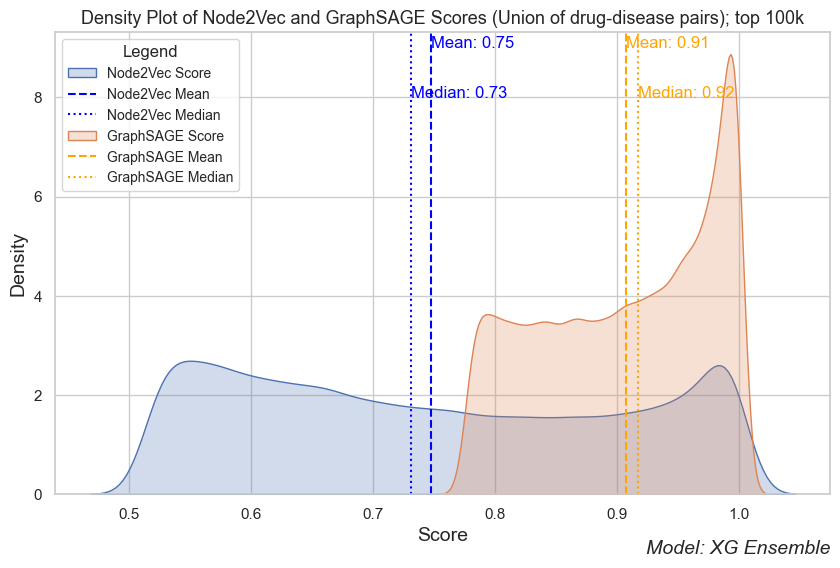

In [24]:
# Plot with KDE (Kernel Density Estimation)
fig = plt.figure(figsize=(10, 6))
sns.kdeplot(df['node2vec_score'], label='Node2Vec Score', fill=True)
plt.axvline(x=df['node2vec_score'].mean(), color='blue', linestyle='--', label='Node2Vec Mean')
plt.axvline(x=df['node2vec_score'].median(), color='blue', linestyle=':', label='Node2Vec Median')
sns.kdeplot(df['graphsage_score'], label='GraphSAGE Score', fill=True)
plt.axvline(x=df['graphsage_score'].mean(), color='orange', linestyle='--', label='GraphSAGE Mean')
plt.axvline(x=df['graphsage_score'].median(), color='orange', linestyle=':', label='GraphSAGE Median')

# Add text
plt.text(x=df['node2vec_score'].mean(), y=9, s=f"Mean: {df['node2vec_score'].mean():.2f}", color='blue')
plt.text(x=df['node2vec_score'].median(), y=8, s=f"Median: {df['node2vec_score'].median():.2f}", color='blue')
plt.text(x=df['graphsage_score'].mean(), y=9, s=f"Mean: {df['graphsage_score'].mean():.2f}", color='orange')
plt.text(x=df['graphsage_score'].median(), y=8, s=f"Median: {df['graphsage_score'].median():.2f}", color='orange')

# Adding titles and labels
plt.title('Density Plot of Node2Vec and GraphSAGE Scores (Union of drug-disease pairs); top 100k', fontsize=13)
plt.xlabel('Score', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Customizing the legend
plt.legend(title='Legend', title_fontsize=12, fontsize=10)
plt.figtext(0.9, 0.01, 'Model: XG Ensemble', ha="right", fontsize=14, fontstyle="italic")

This plot shows the distribution of scores for all drug-disease pairs for XGBoost Ensemble model obtained when using both Node2Vec and GraphSAGE + OpenAI embeddings. We can see that the distribution of top 100 pairs clearly differs as we change the embedding method, with the range of GraphSAGE scores for 100k being much higher than in case of Node2Vec scores. This would indicate that node2vec leads to a bit more 'conservative inference'. 

In [25]:
# overlap 
intersection = df.loc[((df.node2vec_score.notna()) & (df.graphsage_score.notna()) )]
intersection.sort_values('node2vec_score', ascending=False)

,pair,drug_id,drug_name,disease_id,disease_name,node2vec_score,graphsage_score,node2vec_rank,graphsage_rank
144042,CHEMBL.COMPOUND:CHEMBL1628385|MONDO:0005866,CHEMBL.COMPOUND:CHEMBL1628385,PROCAINE BENZYLPENICILLIN,MONDO:0005866,mycobacterium avium complex disease,1.000000,0.999816,0.0,639.0
130088,CHEMBL.COMPOUND:CHEMBL1200881|MONDO:0005866,CHEMBL.COMPOUND:CHEMBL1200881,MINOCYCLINE HYDROCHLORIDE,MONDO:0005866,mycobacterium avium complex disease,0.999999,0.999405,1.0,1795.0
62747,CHEMBL.COMPOUND:CHEMBL1628385|MONDO:0005631,CHEMBL.COMPOUND:CHEMBL1628385,PROCAINE BENZYLPENICILLIN,MONDO:0005631,actinomycosis,0.999999,0.959144,2.0,31793.0
165661,CHEMBL.COMPOUND:CHEMBL3184791|MONDO:0005866,CHEMBL.COMPOUND:CHEMBL3184791,STREPTOMYCIN SULFATE,MONDO:0005866,mycobacterium avium complex disease,0.999998,0.999995,3.0,11.0
148292,CHEMBL.COMPOUND:CHEMBL1628385|MONDO:0015306,CHEMBL.COMPOUND:CHEMBL1628385,PROCAINE BENZYLPENICILLIN,MONDO:0015306,Lemierre syndrome,0.999997,0.998353,4.0,3875.0
...,...,...,...,...,...,...,...,...,...
46745,CHEMBL.COMPOUND:CHEMBL848|MONDO:0007179,CHEMBL.COMPOUND:CHEMBL848,LENALIDOMIDE,MONDO:0007179,autoimmune disease,0.514648,0.888387,99983.0,60537.0
37763,CHEMBL.COMPOUND:CHEMBL31|MONDO:0005091,CHEMBL.COMPOUND:CHEMBL31,GATIFLOXACIN,MONDO:0005091,severe acute respiratory syndrome,0.514624,0.978103,99991.0,21676.0
132559,CHEMBL.COMPOUND:CHEMBL1201171|MONDO:0005723,CHEMBL.COMPOUND:CHEMBL1201171,PRAMOXINE HYDROCHLORIDE,MONDO:0005723,Cryptococcal meningitis,0.514620,0.956567,99992.0,33098.0
60313,CHEMBL.COMPOUND:CHEMBL650|MONDO:0009265,CHEMBL.COMPOUND:CHEMBL650,METHYLPREDNISOLONE,MONDO:0009265,Gaucher disease type I,0.514615,0.846363,99994.0,75149.0


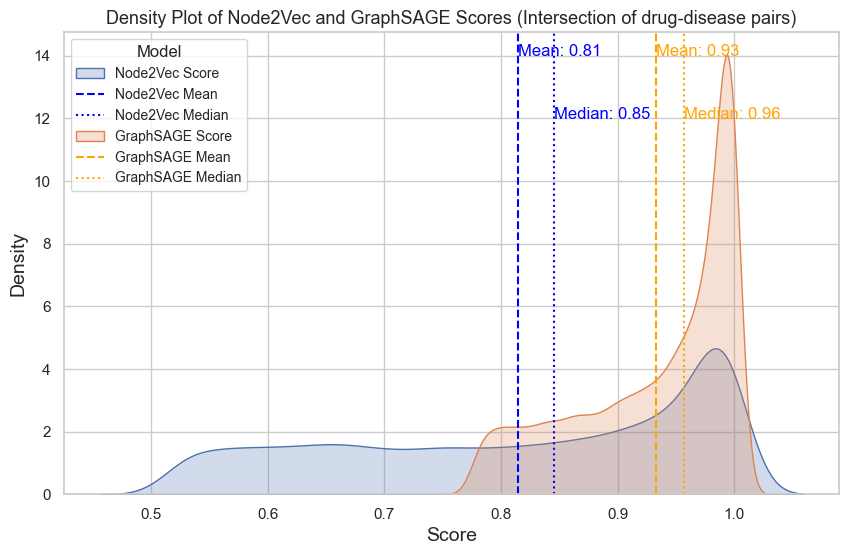

In [26]:
# Plot with KDE (Kernel Density Estimation)
fig = plt.figure(figsize=(10, 6))
sns.kdeplot(intersection['node2vec_score'], label='Node2Vec Score', fill=True)
plt.axvline(x=intersection['node2vec_score'].mean(), color='blue', linestyle='--', label='Node2Vec Mean')
plt.axvline(x=intersection['node2vec_score'].median(), color='blue', linestyle=':', label='Node2Vec Median')
sns.kdeplot(intersection['graphsage_score'], label='GraphSAGE Score', fill=True)
plt.axvline(x=intersection['graphsage_score'].mean(), color='orange', linestyle='--', label='GraphSAGE Mean')
plt.axvline(x=intersection['graphsage_score'].median(), color='orange', linestyle=':', label='GraphSAGE Median')

# Add text
plt.text(x=intersection['node2vec_score'].mean(), y=14, s=f"Mean: {intersection['node2vec_score'].mean():.2f}", color='blue')
plt.text(x=intersection['node2vec_score'].median(), y=12, s=f"Median: {intersection['node2vec_score'].median():.2f}", color='blue')
plt.text(x=intersection['graphsage_score'].mean(), y=14, s=f"Mean: {intersection['graphsage_score'].mean():.2f}", color='orange')
plt.text(x=intersection['graphsage_score'].median(), y=12, s=f"Median: {intersection['graphsage_score'].median():.2f}", color='orange')

# Adding titles and labels
plt.title('Density Plot of Node2Vec and GraphSAGE Scores (Intersection of drug-disease pairs)', fontsize=13)
plt.xlabel('Score', fontsize=14)
plt.ylabel('Density', fontsize=14)

# Customizing the legend
plt.legend(title='Model', title_fontsize=12, fontsize=10)


Similarly to the previous plot, node2vec results are much more conservative when we only look at the intersection of drug-disease pairs.

## Ranking Comparison for top 10 and top 100 

The last type of analysis to try is to compare the rankings for some drug-disease pairs across:


In [89]:
example_pairs = ['CHEMBL.COMPOUND:CHEMBL1282|MONDO:0005055','CHEMBL.COMPOUND:CHEMBL3137343|MONDO:0000430','CHEMBL.COMPOUND:CHEMBL85|MONDO:0001156','CHEMBL.COMPOUND:CHEMBL1200955|MONDO:0009303','CHEMBL.COMPOUND:CHEMBL628|MONDO:0001999','CHEMBL.COMPOUND:CHEMBL1711|MONDO:0009691','CHEMBL.COMPOUND:CHEMBL428880|MONDO:0012040','CHEMBL.COMPOUND:CHEMBL628|MONDO:0002275','CHEMBL.COMPOUND:CHEMBL1043|MONDO:0018747']

example_df = intersection.loc[intersection.pair.isin(example_pairs)]

example_df

,pair,drug_id,drug_name,disease_id,disease_name,node2vec_score,graphsage_score,node2vec_rank,graphsage_rank
788,CHEMBL.COMPOUND:CHEMBL428880|MONDO:0012040,CHEMBL.COMPOUND:CHEMBL428880,CROMOLYN,MONDO:0012040,inflammatory bowel disease 9,0.998791,0.999922,1061.0,287.0
2594,CHEMBL.COMPOUND:CHEMBL1282|MONDO:0005055,CHEMBL.COMPOUND:CHEMBL1282,IMIQUIMOD,MONDO:0005055,Kaposi's sarcoma,0.934063,0.999972,17265.0,77.0
31935,CHEMBL.COMPOUND:CHEMBL628|MONDO:0001999,CHEMBL.COMPOUND:CHEMBL628,PENTOXIFYLLINE,MONDO:0001999,primary pulmonary hypertension,0.976962,0.999947,8675.0,185.0
43018,CHEMBL.COMPOUND:CHEMBL3137343|MONDO:0000430,CHEMBL.COMPOUND:CHEMBL3137343,PEMBROLIZUMAB,MONDO:0000430,mature T-cell and NK-cell non-Hodgkin lymphoma,0.877036,0.999951,26556.0,169.0
57927,CHEMBL.COMPOUND:CHEMBL85|MONDO:0001156,CHEMBL.COMPOUND:CHEMBL85,RISPERIDONE,MONDO:0001156,borderline personality disorder,0.998979,0.999949,921.0,176.0
80655,CHEMBL.COMPOUND:CHEMBL628|MONDO:0002275,CHEMBL.COMPOUND:CHEMBL628,PENTOXIFYLLINE,MONDO:0002275,generalized atherosclerosis,0.702659,0.999921,55148.0,289.0
148782,CHEMBL.COMPOUND:CHEMBL1200955|MONDO:0009303,CHEMBL.COMPOUND:CHEMBL1200955,MYCOPHENOLATE MOFETIL HYDROCHLORIDE,MONDO:0009303,anti-glomerular basement membrane disease,0.885438,0.999948,25257.0,184.0


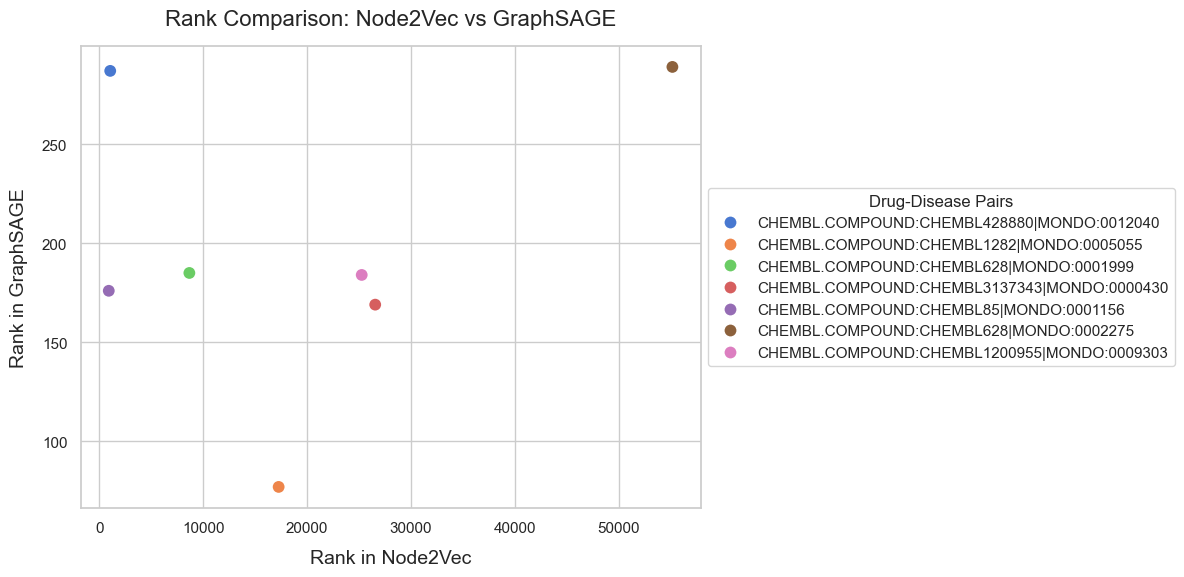

In [92]:
# Set the style and color palette
sns.set(style="whitegrid", palette="muted")

# Create the scatter plot with Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(x='node2vec_rank', y='graphsage_rank', s=100, edgecolor='w', linewidth=1.5, hue='pair', data=example_df)

# Improve the labels and title
plt.xlabel('Rank in Node2Vec', fontsize=14, labelpad=10)
plt.ylabel('Rank in GraphSAGE', fontsize=14, labelpad=10)
plt.title('Rank Comparison: Node2Vec vs GraphSAGE', fontsize=16, pad=15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Drug-Disease Pairs')

# Show the plot
plt.show()

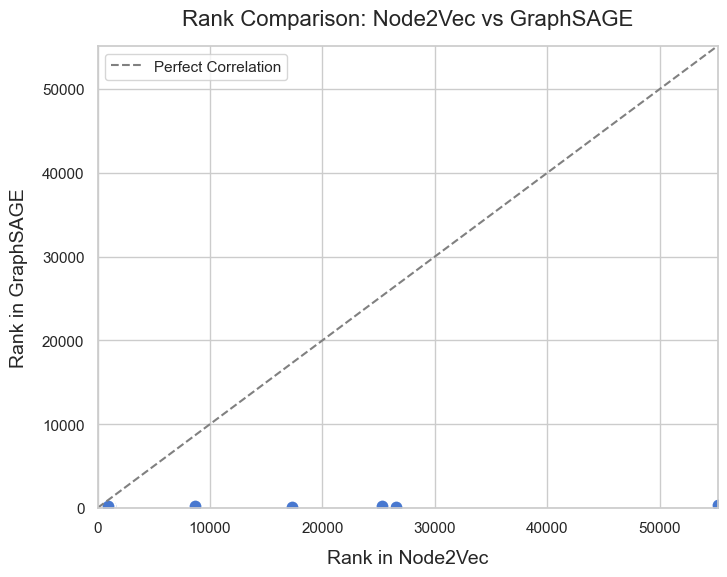

In [68]:
# Create the scatter plot with Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(x=ranks_n2v, y=ranks_graphsage, s=100, edgecolor='w', linewidth=1.5)

# Improve the labels and title
plt.xlabel('Rank in Node2Vec', fontsize=14, labelpad=10)
plt.ylabel('Rank in GraphSAGE', fontsize=14, labelpad=10)
plt.title('Rank Comparison: Node2Vec vs GraphSAGE', fontsize=16, pad=15)

# Add a diagonal line representing perfect correlation
max_val = max(max(ranks_n2v), max(ranks_graphsage))
plt.plot([0, max_val], [0, max_val], ls='--', color='gray', label='Perfect Correlation')

# Optional: Add legend to indicate what the line represents
plt.legend()

# Adjust the axis limits for better visualization
plt.xlim([0, max_val])
plt.ylim([0, max_val])

# Show the plot
plt.show()

# Conclusion/Future

* Node2vec seems to outperform graphsage in terms of downstream task performance, for some metrics significantly. Therefore it might be more optimal to use as a a default in our pipeline.
* Those results even outperformed Chunyu's results from the original publication (great success)
* In terms of Matrix Output Generation - there is an overlap of approx 27k drugs; Node2Vec results seem to be more conservative than GraphSage

# References

* MLFlow Node2vec Run: [run-node2vec-iter10](https://mlflow.platform.dev.everycure.org/)
* MLFlow GraphSage Run: [full_matrix_run](https://mlflow.platform.dev.everycure.org/)
* More detailed report with all code: [node2vec_exploration/neo4j_node2vec_report_full.ipynb](https://github.com/everycure-org/lab-notebooks/tree/main/node2vec_exploration)
* Intersection Matrix: [google sheet](https://docs.google.com/spreadsheets/d/1vHpvMUwDjG49ofHNvXBTTm2Hp4AgR0i1/edit?usp=share_link&ouid=106105428319804615712&rtpof=true&sd=true)